In [1]:
%matplotlib inline
#%load_ext lab_black

nb_samples = 30
list_features = ["track_unwrapped", "longitude", "latitude", "altitude"]
nb_features = len(list_features)
flow = "162-216"
runway = "14"

In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from traffic.data.datasets import landing_zurich_2019 as t
from traffic.algorithms.clustering import prepare_features

# t_f = (
#     t.query("track == track").resample(nb_samples).unwrap("track").eval(max_workers=10)
# )
t_f = (
    t.query(f"track == track and initial_flow == '{flow}' and runway =='{runway}'")
    .resample(30)
    .unwrap("track")
    .eval(max_workers=10)
)
# t_f = t.query("track == track and initial_flow in ['162-216', '90-132'] and runway in ['14', '28']").unwrap("track").resample(30).eval(max_workers=10)

t_f.to_parquet(f"data/lszh_{flow}_{runway}.parquet")
X = prepare_features(t_f, None, list_features)
X = MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)
np.save(f"data/lszh_{flow}_{runway}.npy", X)

/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pkg_resources/__init__.py:1151: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name
/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/ipyleaflet/leaflet.py:317: DeprecationWarning: metadata {'dtype': None} was set from the constructor. With traitlets 4.1, metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  data = Dataset().tag(dtype=None, sync=True, to_json=ds_x_to_json)
/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pyarrow/pandas_compat.py:294: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif isinstance(name, collections.Sequence):


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from traffic.core import Traffic
from artefact import Autoencoder
from artefact.clustering import get_latent
from artefact.training import train
from artefact.plot import plot_loss, plot_latent, plot_latent_and_trajs

t = Traffic.from_file(f"data/lszh_{flow}_{runway}.parquet")
X = np.load(f"data/lszh_{flow}_{runway}.npy")
model_ = Autoencoder((nb_samples * nb_features, 32, 8, 2))
device = 0

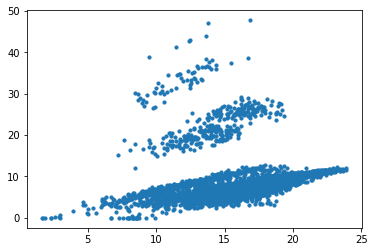

In [4]:
model, loss = train(
    model_, X, device=device, nb_iterations=10000, batch_size=len(X), lambda_kl=0
)
torch.save(model.state_dict(), f"models/{flow}_{runway}_ae_10000.pth")
plot_latent(X, model, device)

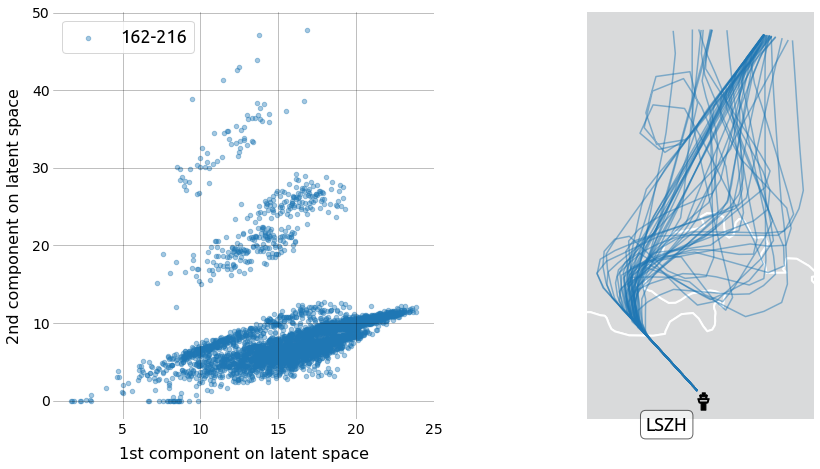

In [5]:
model.load_state_dict(torch.load(f"models/{flow}_{runway}_ae_10000.pth"))
lat = get_latent(X, model, device)
plot_latent_and_trajs(t, lat, f"figs/{flow}_{runway}_latent_ae.png", runway=14)

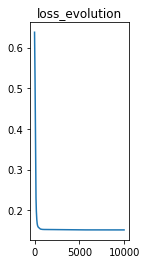

In [6]:
plot_loss(loss["loss"])

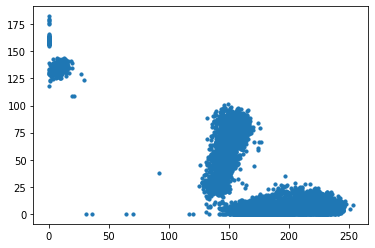

In [7]:
model, loss = train(
    model_, X, device=device, nb_iterations=500, batch_size=1000, lambda_kl=0.05
)
torch.save(model.state_dict(), f"models/{flow}_{runway}_tsne_500_005.pth")
plot_latent(X, model, device)

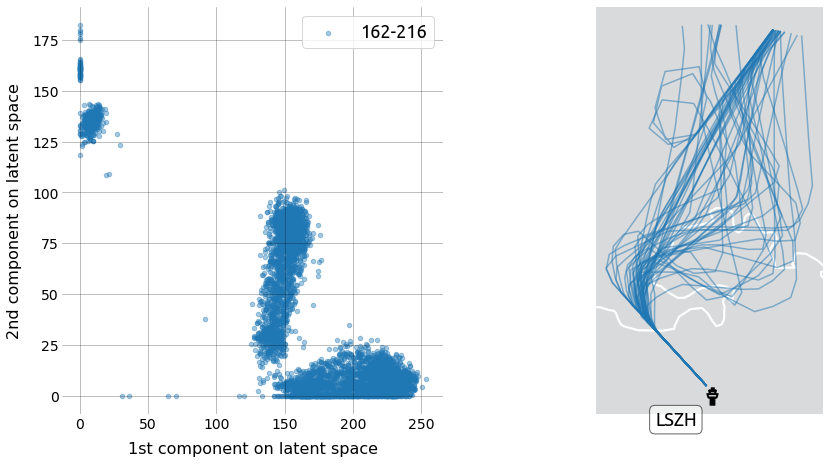

In [8]:
model.load_state_dict(torch.load(f"models/{flow}_{runway}_tsne_500_005.pth"))
lat = get_latent(X, model, device)
plot_latent_and_trajs(
    t, lat, f"figs/{flow}_{runway}_latent_tsne_500_005.png", runway=14
)

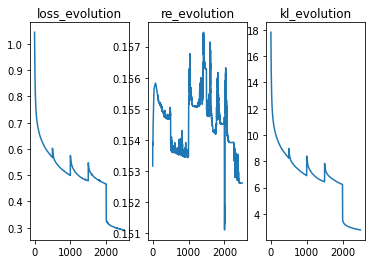

In [9]:
plot_loss(loss["loss"], loss["re_loss"], loss["kl_loss"])

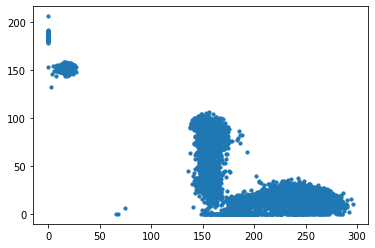

In [10]:
model, loss = train(
    model_, X, device=device, nb_iterations=500, batch_size=1000, lambda_kl=0.01
)
torch.save(model.state_dict(), f"models/{flow}_{runway}_tsne_500_001.pth")
plot_latent(X, model, device)

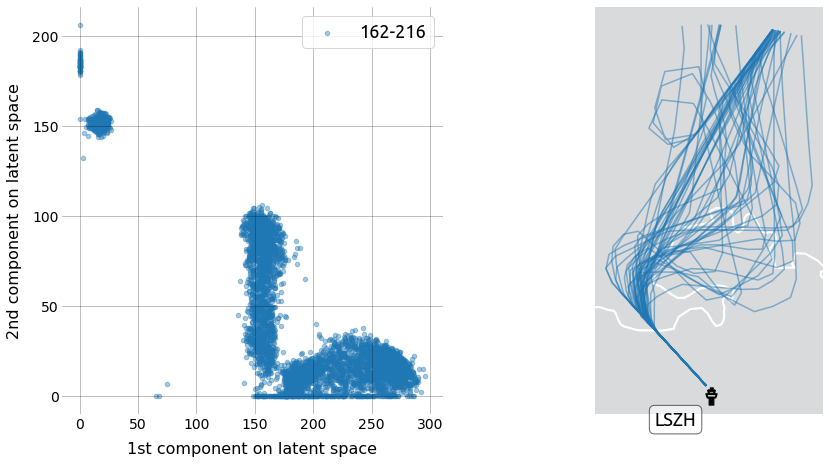

In [11]:
model.load_state_dict(torch.load(f"models/{flow}_{runway}_tsne_500_001.pth"))
lat = get_latent(X, model, device)
plot_latent_and_trajs(
    t, lat, f"figs/{flow}_{runway}_latent_tsne_500_001.png", runway=14
)

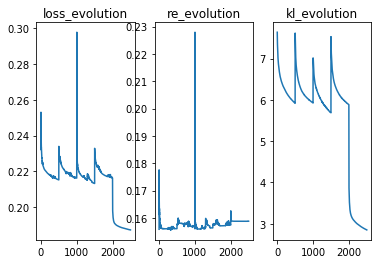

In [12]:
plot_loss(loss["loss"], loss["re_loss"], loss["kl_loss"])

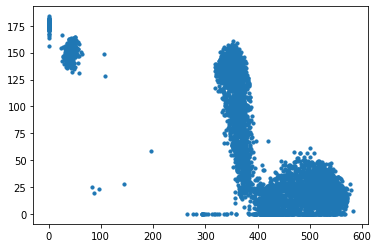

In [13]:
model, loss = train(
    model_, X, device=device, nb_iterations=500, batch_size=1000, lambda_kl=0.07
)
torch.save(model.state_dict(), f"models/{flow}_{runway}_tsne_500_007.pth")
plot_latent(X, model, device)

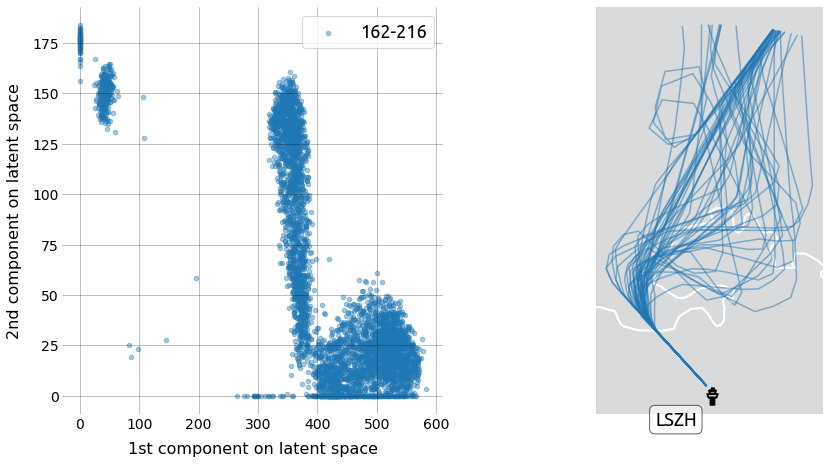

In [14]:
model.load_state_dict(torch.load(f"models/{flow}_{runway}_tsne_500_007.pth"))
lat = get_latent(X, model, device)
plot_latent_and_trajs(t, lat, f"figs/{flow}_{runway}_latent_tsne.png", runway=14)

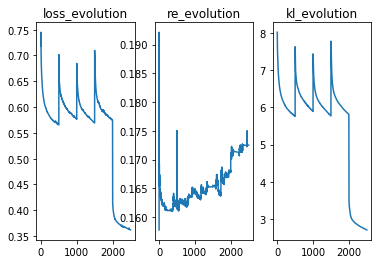

In [15]:
plot_loss(loss["loss"], loss["re_loss"], loss["kl_loss"])

In [16]:
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

from traffic.core import Traffic

from artefact import AutoencoderTSNE, Autoencoder

t = Traffic.from_file(f"data/lszh_{flow}_{runway}.parquet")
list_features = ["track_unwrapped", "longitude", "latitude", "altitude"]
# list_features = ["longitude", "latitude"]

nb_flights = len(t)
nb_samples = len(t[0])
nb_features = len(list_features)
lambda_kl = 0.7
print(f"nb_flights: {len(t)}")

device = 2

algo_clustering = AutoencoderTSNE(
    gpu=device,
    batch_size=1000,
    model=Autoencoder((nb_samples * nb_features, 32, 8, 2)),
    lambda_kl=lambda_kl,
    nb_iterations=800,
    algo_clustering=GaussianMixture(n_components=4),
    distance_trajectory="euclidean",  # delta_max
    savepath=f"models/model_{flow}_{runway}.pth",
)
model = algo_clustering.model

t_tsne = t.clustering(
    nb_samples=None,
    features=list_features,
    clustering=algo_clustering,
    transform=MinMaxScaler(feature_range=(-1, 1)),
).fit_predict()

t_tsne.to_pickle(f"test/t_tsne_{flow}_{runway}.pkl")
t_tsne.groupby(["cluster"]).agg({"flight_id": "nunique"})

nb_flights: 4437


,flight_id
cluster,
0,1479
1,1711
2,363
3,884


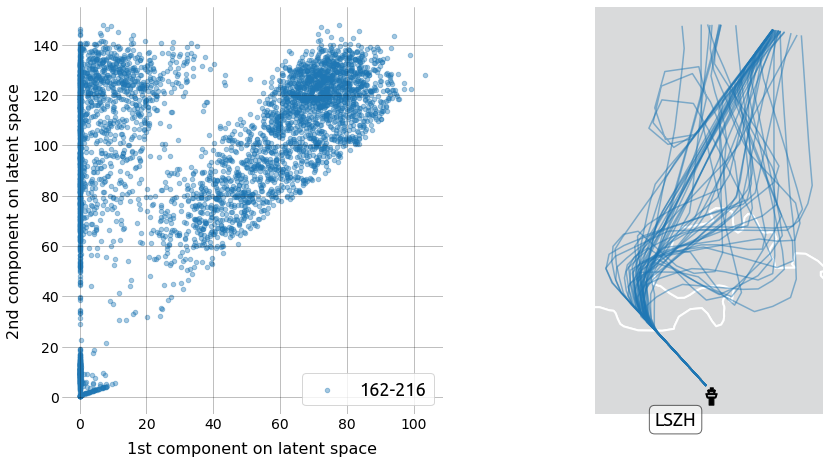

In [17]:
from artefact.plot import plot_latent_and_trajs

plot_latent_and_trajs(
    t, algo_clustering.get_latent(), f"figs/{flow}_{runway}_latent.png", runway=14
)

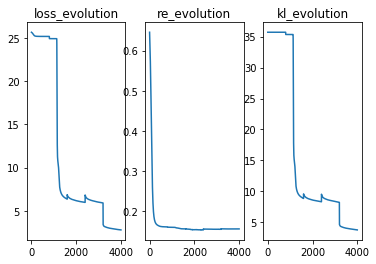

In [18]:
from artefact.plot import plot_loss

loss = algo_clustering.loss
plot_loss(loss["loss"], loss["re_loss"], loss["kl_loss"])

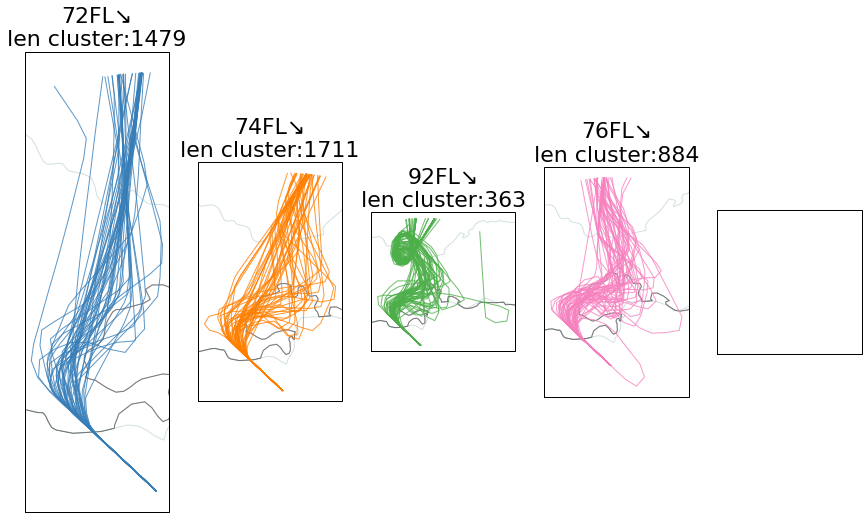

In [19]:
from traffic.core import Traffic
from artefact.plot import plot_trajs

t_tsne = Traffic.from_file(f"test/t_tsne_{flow}_{runway}.pkl")
plot_trajs(t_tsne, None)

        flight_id        re                    
          nunique      mean       min       max
cluster                                        
-1           3584  0.197725  0.032818  0.706969
 0            279  0.187105  0.116673  0.261793
 1             48  0.155819  0.098144  0.224529
 2            274  0.067094  0.000000  1.000000
 3             82  0.140819  0.073675  0.198710
 4             75  0.117593  0.056240  0.161702
 5             67  0.116373  0.072635  0.186586
 6             28  0.217271  0.182721  0.269829


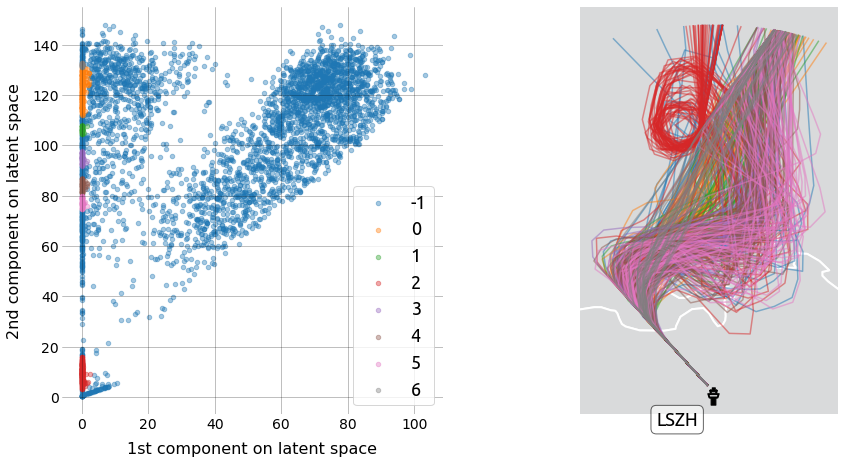

In [20]:
from sklearn.cluster import DBSCAN
from artefact import Autoencoder
from artefact.utils import pretrained_clust

eps, min_samples = 1.6, 40


def eps_f(eps):
    return str(eps).replace(".", "")


ae_tsne, t_tsne = pretrained_clust(
    f"data/lszh_{flow}_{runway}.parquet",
    list_features,
    DBSCAN(eps=eps, min_samples=min_samples),
    Autoencoder((nb_samples * nb_features, 32, 8, 2)),
    f"models/model_{flow}_{runway}.pth",
    f"test/t_tsne_dbscan_{flow}_{runway}.pkl",
)
from artefact.plot import plot_latent_and_trajs

plot_latent_and_trajs(
    t_tsne,
    ae_tsne.get_latent(),
    f"figs/{flow}_{runway}_latent_clusters_dbscan_{eps_f(eps)}_{min_samples}.png",
    plot_clusters=True,
    runway=14,
)

        flight_id        re                         score                    
          nunique      mean       min       max      mean       min       max
cluster                                                                      
0             882  0.151379  0.048305  0.515285  0.760856  0.319319  0.824513
1            1711  0.170642  0.043465  0.645178  0.790775  0.000000  0.869838
2             363  0.088193  0.000000  1.000000  0.922524  0.279375  1.000000
3            1481  0.245416  0.142760  0.435277  0.837682  0.243988  0.908634


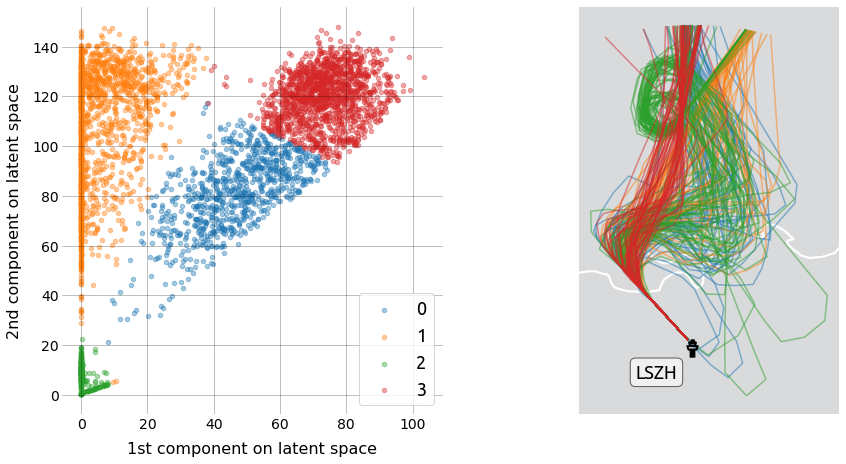

In [21]:
from sklearn.mixture import GaussianMixture
from artefact import Autoencoder
from artefact.utils import pretrained_clust

ae_tsne, t_tsne = pretrained_clust(
    f"data/lszh_{flow}_{runway}.parquet",
    list_features,
    GaussianMixture(n_components=4),
    Autoencoder((nb_samples * nb_features, 32, 8, 2)),
    f"models/model_{flow}_{runway}.pth",
    f"test/t_tsne_gm_{flow}_{runway}.pkl",
)
from artefact.plot import plot_latent_and_trajs

plot_latent_and_trajs(
    t_tsne,
    ae_tsne.get_latent(),
    f"figs/{flow}_{runway}_latent_clusters_gm.png",
    plot_clusters=True,
    runway=14,
)

        flight_id        re                         score                    
          nunique      mean       min       max      mean       min       max
cluster                                                                      
0             894  0.151694  0.048305  0.515285  0.763871  0.330665  0.827621
1            1469  0.245992  0.142760  0.435277  0.839522  0.255223  0.909591
2            1711  0.170642  0.043465  0.645178  0.792574  0.000000  0.871738
3             363  0.088193  0.000000  1.000000  0.923381  0.289404  1.000000


top outliers
                      re
flight_id              
SWR109R_12259  1.000000
SWR116W_17131  0.706969
SWR116W_18016  0.652780
EWG7ME_1079    0.645178
EWG764_1912    0.553948
SWR116W_17519  0.553512
SWR105K_17983  0.515285
SWR1059_12421  0.503602
SWR1197_17339  0.490485
EWG764_1910    0.487700


/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])


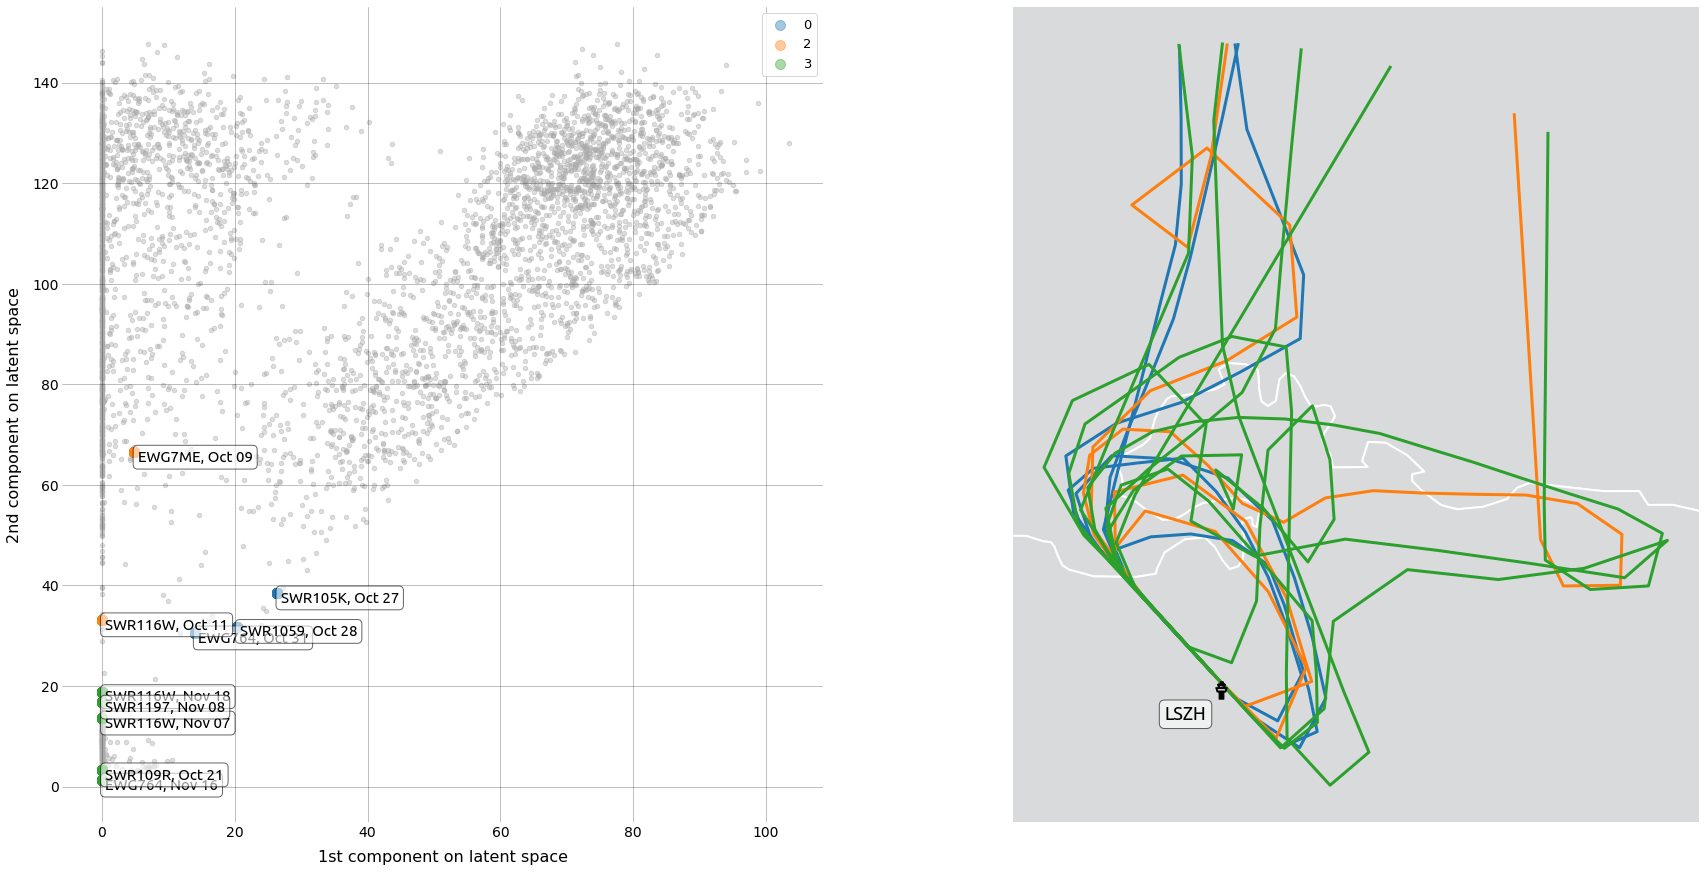

In [22]:
# outliers based on reconstruction error (re)
import numpy as np
from sklearn.mixture import GaussianMixture
from traffic.core import Traffic
from artefact import Autoencoder
from artefact.utils import pretrained_clust
from artefact.plot import plot_latent_and_trajs_outliers

nb_samples = 30
flow = "162-216"
runway = "14"
list_features = ["track_unwrapped", "longitude", "latitude", "altitude"]
nb_features= len(list_features)

ae_tsne, t_tsne = pretrained_clust(
    f"data/lszh_{flow}_{runway}.parquet",
    list_features,
    GaussianMixture(n_components=4),
    Autoencoder((nb_samples * nb_features, 32, 8, 2)),
    f"models/model_{flow}_{runway}.pth",
    f"test/t_tsne_gm_{flow}_{runway}.pkl",
)

re = t_tsne.data.re
threshold = np.percentile(re, 95)
outliers = Traffic.from_flights(
    f for f in t_tsne if f.data.re.mean() > threshold
)

plot_latent_and_trajs_outliers(
    Traffic.from_file(f"test/t_tsne_gm_{flow}_{runway}.pkl"),
    ae_tsne.get_latent(),
    outliers,
    f"figs/{flow}_{runway}_latent_clusters_outliers_re_gm.png",
    nb_top_outliers=10,
    plot_callsigns=True,
)

        flight_id        re                         score                    
          nunique      mean       min       max      mean       min       max
cluster                                                                      
0             886  0.151620  0.048305  0.515285  0.760934  0.319704  0.824436
1            1477  0.245526  0.142760  0.435277  0.837689  0.243280  0.908664
2             363  0.088193  0.000000  1.000000  0.922472  0.278794  1.000000
3            1711  0.170642  0.043465  0.645178  0.790655  0.000000  0.869773


top outliers
                   score
flight_id              
SWR75G_7124    0.000000
SWR101R_14535  0.023931
SWR140T_17887  0.226991
SWR140T_17885  0.243280
SWR117P_17690  0.245973
SWR117P_5444   0.263397
DFNJP_2305     0.278794
SWR140T_17732  0.306824
SWR77E_9364    0.319126
KLM1963_4632   0.319704


/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])


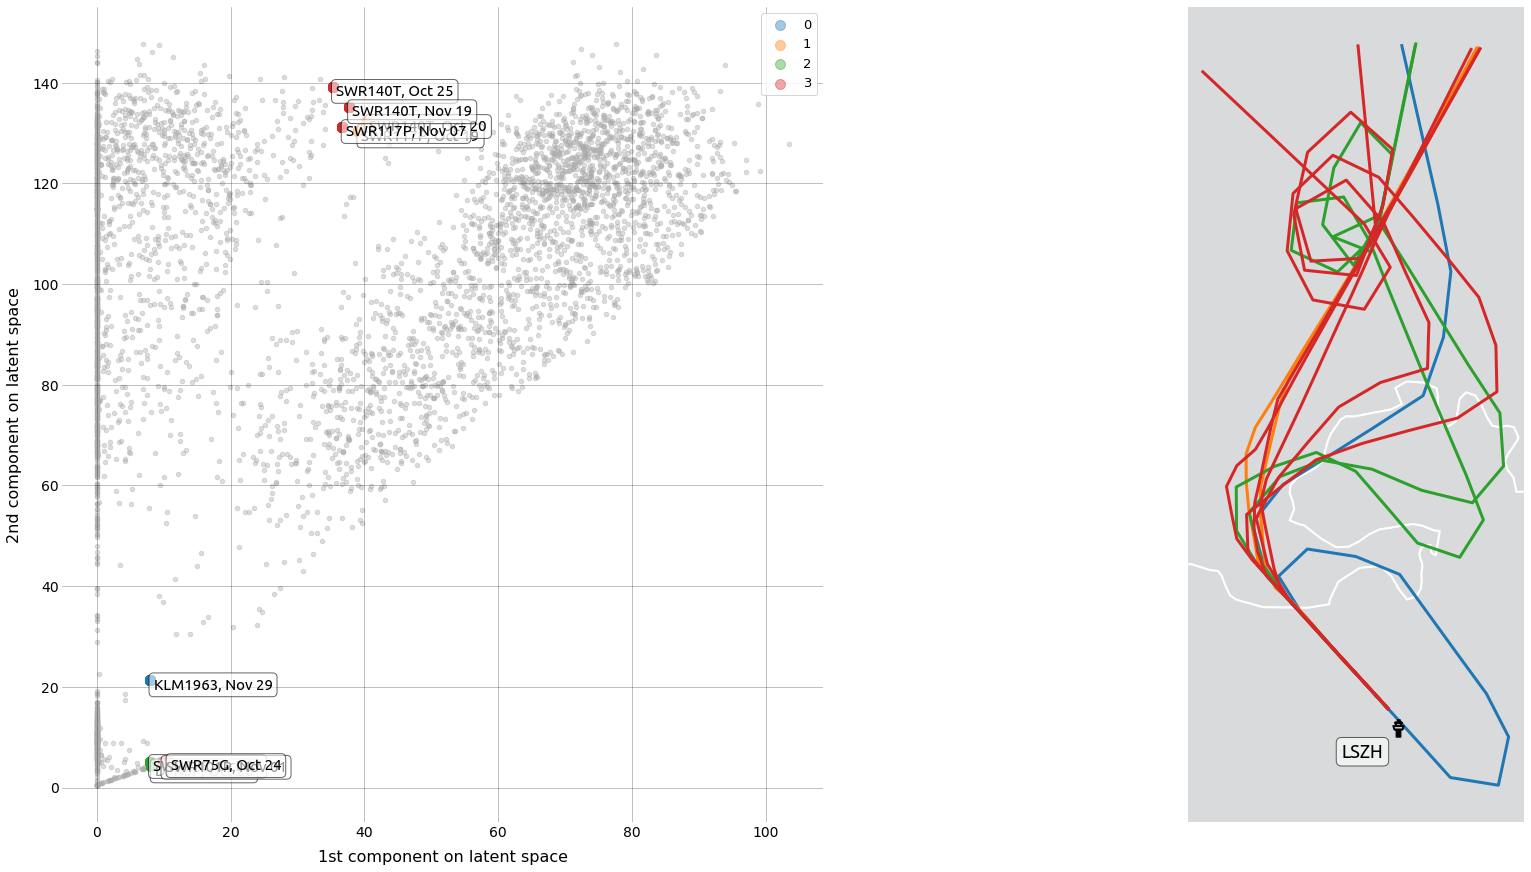

In [23]:
# outliers based on GMM score 
import numpy as np
from sklearn.mixture import GaussianMixture
from traffic.core import Traffic
from artefact import Autoencoder
from artefact.utils import pretrained_clust
from artefact.plot import plot_latent_and_trajs_outliers

nb_samples = 30
flow = "162-216"
runway = "14"
list_features = ["track_unwrapped", "longitude", "latitude", "altitude"]
nb_features= len(list_features)

ae_tsne, t_tsne = pretrained_clust(
    f"data/lszh_{flow}_{runway}.parquet",
    list_features,
    GaussianMixture(n_components=4),
    Autoencoder((nb_samples * nb_features, 32, 8, 2)),
    f"models/model_{flow}_{runway}.pth",
    f"test/t_tsne_gm_{flow}_{runway}.pkl",
)

scores = t_tsne.data.score
threshold = np.percentile(scores, 0.25)
outliers = Traffic.from_flights(
    f for f in t_tsne if f.data.score.mean() < threshold
)

plot_latent_and_trajs_outliers(
    Traffic.from_file(f"test/t_tsne_gm_{flow}_{runway}.pkl"),
    ae_tsne.get_latent(),
    outliers,
    f"figs/{flow}_{runway}_latent_clusters_outliers_score_gm.png",
    nb_top_outliers=10,
    plot_callsigns=True,
    re_or_score="score",
)

In [24]:
from traffic.core import Traffic
from artefact.utils import duration_cumdist_cluster

flow = "162-216"
runway = "14"

dur_dist = duration_cumdist_cluster(
    Traffic.from_file(f"test/t_tsne_gm_{flow}_{runway}.pkl")
)
dur_dist

,flight_id,duration,cumdist
cluster,,,
0,886,14.693002,30.377659
1,1477,11.025051,24.971021
2,363,20.438017,41.384815
3,1711,12.912332,27.852932


In [25]:
duration_cumdist_cluster(outliers)

,flight_id,duration,cumdist
cluster,,,
0,1,23.00,47.856162
1,2,11.50,24.925316
2,4,21.25,42.719921
3,5,15.00,33.397899


In [26]:
from artefact.utils import duration_cumdist_flight
from artefact.plot import dur_dist_plot

dur_dist = duration_cumdist_flight(outliers)
dur_dist_plot(dur_dist)

alt.Chart(...)

In [27]:
from traffic.core import Traffic
from artefact.utils import duration_cumdist_flight
from artefact.plot import dur_dist_plot

flow = "162-216"
runway = "14"

dur_dist = duration_cumdist_flight(
    Traffic.from_file(f"test/t_tsne_gm_{flow}_{runway}.pkl")
)
dur_dist_plot(dur_dist)

alt.Chart(...)